# Data Generation

In [4]:
# We generate synthetic data.
seq_len = 512
t = np.linspace(0, 20, seq_len)
clean_data = np.sin(t) + 0.1 * np.random.normal(0, 1, seq_len)

# Wrap in Pandas for sktime (Required for .fit())
# TTM expects a proper time index to infer frequency
y_dummy = pd.Series(
    clean_data, 
    index=pd.date_range("2024-01-01", periods=seq_len, freq="h")
)

# Victim Model

In [6]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.ttm import TinyTimeMixerForecaster

print("Loading IBM TTM via sktime...")

# Initialize the wrapper
ttm_wrapper = TinyTimeMixerForecaster(
    model_path="ibm/TTM",
    fit_strategy="zero-shot"
)
ttm_wrapper.fit(y_dummy, fh=[1])

# sktime hides the gradients, so we extract the raw PyTorch model 
# stored inside the wrapper to perform the white-box attack.
model = ttm_wrapper.model 
model.eval() # Set to evaluation mode

Loading IBM TTM via sktime...


TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

# Forecast

In [7]:
input_tensor = torch.tensor(clean_data, dtype=torch.float32).view(1, seq_len, 1)
input_tensor.requires_grad = True

output = model(past_values=input_tensor)
clean_forecast = output.prediction_outputs.detach().numpy()[0, :, 0]

# Attack

In [8]:
# Goal: Push the forecast UPWARDS artificially.
# We define a "Target" that is ridiculously high (+10.0 flat line)
# and calculate how to change the input to match it.

target = torch.full((1, 96, 1), 10.0) 
loss_fn = torch.nn.MSELoss()

# A. Forward Pass
pred = output.prediction_outputs
loss = loss_fn(pred, target)

# B. Backward Pass (Calculate Gradients)
model.zero_grad()
loss.backward()

# C. Create Adversarial Noise
# "epsilon" is the strength of the attack (invisible to human eye)
epsilon = 0.05 
data_grad = input_tensor.grad.data
# FGSM formula: Input + Epsilon * Sign(Gradient)
adversarial_noise = epsilon * data_grad.sign()

# D. Create the "Dirty" Input
perturbed_input = input_tensor + adversarial_noise

# Dirty Forecat

In [9]:
# Run the model on the noisy data (without gradients this time)
with torch.no_grad():
    dirty_output = model(past_values=perturbed_input)
    dirty_forecast = dirty_output.prediction_outputs.numpy()[0, :, 0]

# Visualization

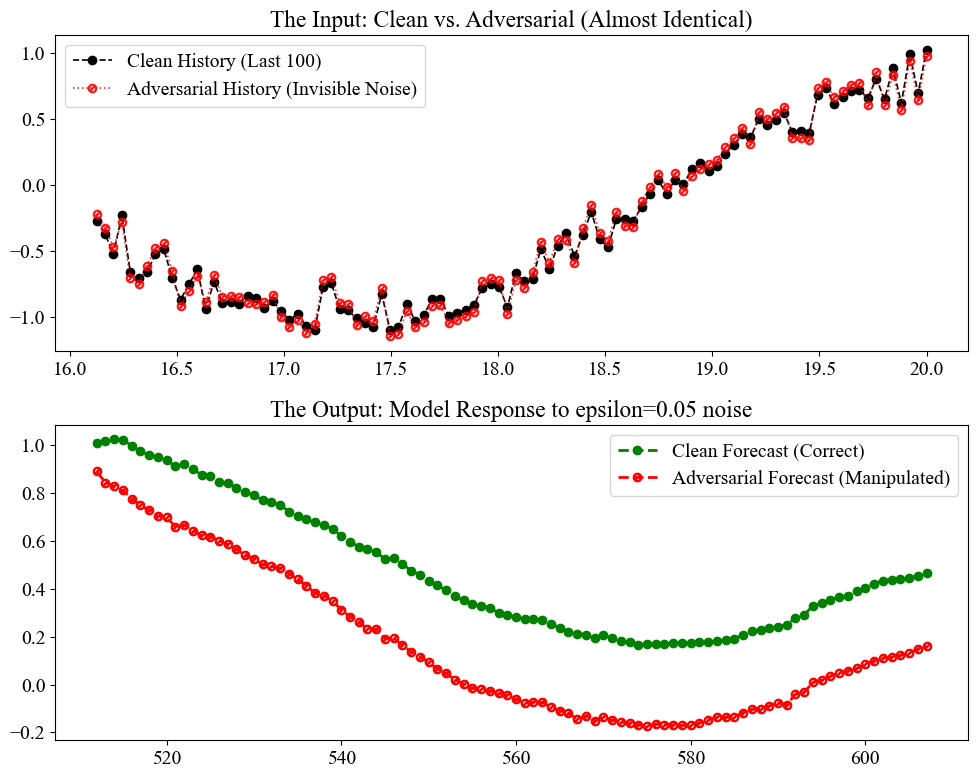

In [13]:
plt.figure(figsize=(10, 8))

# Panel 1: The Input Data (Can you see the difference?)
plt.subplot(2, 1, 1)
plt.plot(t[-100:], clean_data[-100:], label="Clean History (Last 100)", color="black")
plt.plot(t[-100:], perturbed_input.detach().numpy()[0, -100:, 0], 
         label="Adversarial History (Invisible Noise)", 
         color="red", linestyle=":", alpha=0.8)
plt.title("The Input: Clean vs. Adversarial (Almost Identical)")
plt.legend()

# Panel 2: The Forecast (Total Collapse)
plt.subplot(2, 1, 2)
# Create forecast timeline
forecast_idx = np.arange(seq_len, seq_len + 96)
plt.plot(forecast_idx, clean_forecast, label="Clean Forecast (Correct)", color="green", linewidth=2)
plt.plot(forecast_idx, dirty_forecast, label="Adversarial Forecast (Manipulated)", color="red", linewidth=2)
plt.title(f"The Output: Model Response to epsilon={epsilon} noise")
plt.legend()

plt.tight_layout()
plt.show()